In [1]:
import sys
sys.executable

'C:\\ProgramData\\Anaconda3\\envs\\craft_model\\python.exe'

In [8]:
import sys
import os
import time
import argparse

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from PIL import Image

import cv2
from skimage import io
import numpy as np
import craft_utils
import imgproc
import file_utils
import json
import zipfile

from craft import CRAFT

from collections import OrderedDict
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

def str2bool(v):
    return v.lower() in ("yes", "y", "true", "t", "1")

In [3]:
def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()
    canvas_size=2280
    mag_ratio=1.5
    show_time=False
    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    if show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text


In [21]:
def craft(tf1):
    net = CRAFT()     # initialize
    trained_model='weights/craft_mlt_25k.pth'
    text_threshold=0.7
    low_text=0.5
    link_threshold=.9
    cuda=False
    canvas_size=1280
    
    poly=False
    
#     test_folder='/data/'
    refine=False
    refiner_model='weights/craft_refiner_CTW1500.pth'
    
    result_folder = './result/'
    if not os.path.isdir(result_folder):
        os.mkdir(result_folder)
    print(tf1)
    image_list, _, _ = file_utils.get_files(tf1)
    if(image_list==[]):
        image_list=[tf1]
    print('Loading weights from checkpoint (' + trained_model + ')')
    if cuda:
        net.load_state_dict(copyStateDict(torch.load(trained_model)))
    else:
        net.load_state_dict(copyStateDict(torch.load(trained_model, map_location='cpu')))

    if cuda:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()

    # LinkRefiner
    refine_net = None
    if refine:
        from refinenet import RefineNet
        refine_net = RefineNet()
        print('Loading weights of refiner from checkpoint (' + refiner_model + ')')
        if cuda:
            refine_net.load_state_dict(copyStateDict(torch.load(refiner_model)))
            refine_net = refine_net.cuda()
            refine_net = torch.nn.DataParallel(refine_net)
        else:
            refine_net.load_state_dict(copyStateDict(torch.load(refiner_model, map_location='cpu')))

        refine_net.eval()
        poly = True

    t = time.time()

    # load data
    for k, image_path in enumerate(image_list):
        print(image_path)
        print("Test image {:d}/{:d}: {:s}".format(k+1, len(image_list), image_path), end='\r')
        image = imgproc.loadImage(image_path)

        bboxes, polys, score_text = test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net)
#         print(bboxes)
        # save score text
        filename, file_ext = os.path.splitext(os.path.basename(image_path))
        mask_file = result_folder + "/res_" + filename + '_mask.jpg'
        cv2.imwrite(mask_file, score_text)
    
        file_utils.saveResult(image_path, image[:,:,::-1], polys, dirname=result_folder)
        f1 = result_folder + "/res_" + filename + '.jpg'
        display(Image(filename=f1))

    print("elapsed time : {}s".format(time.time() - t))


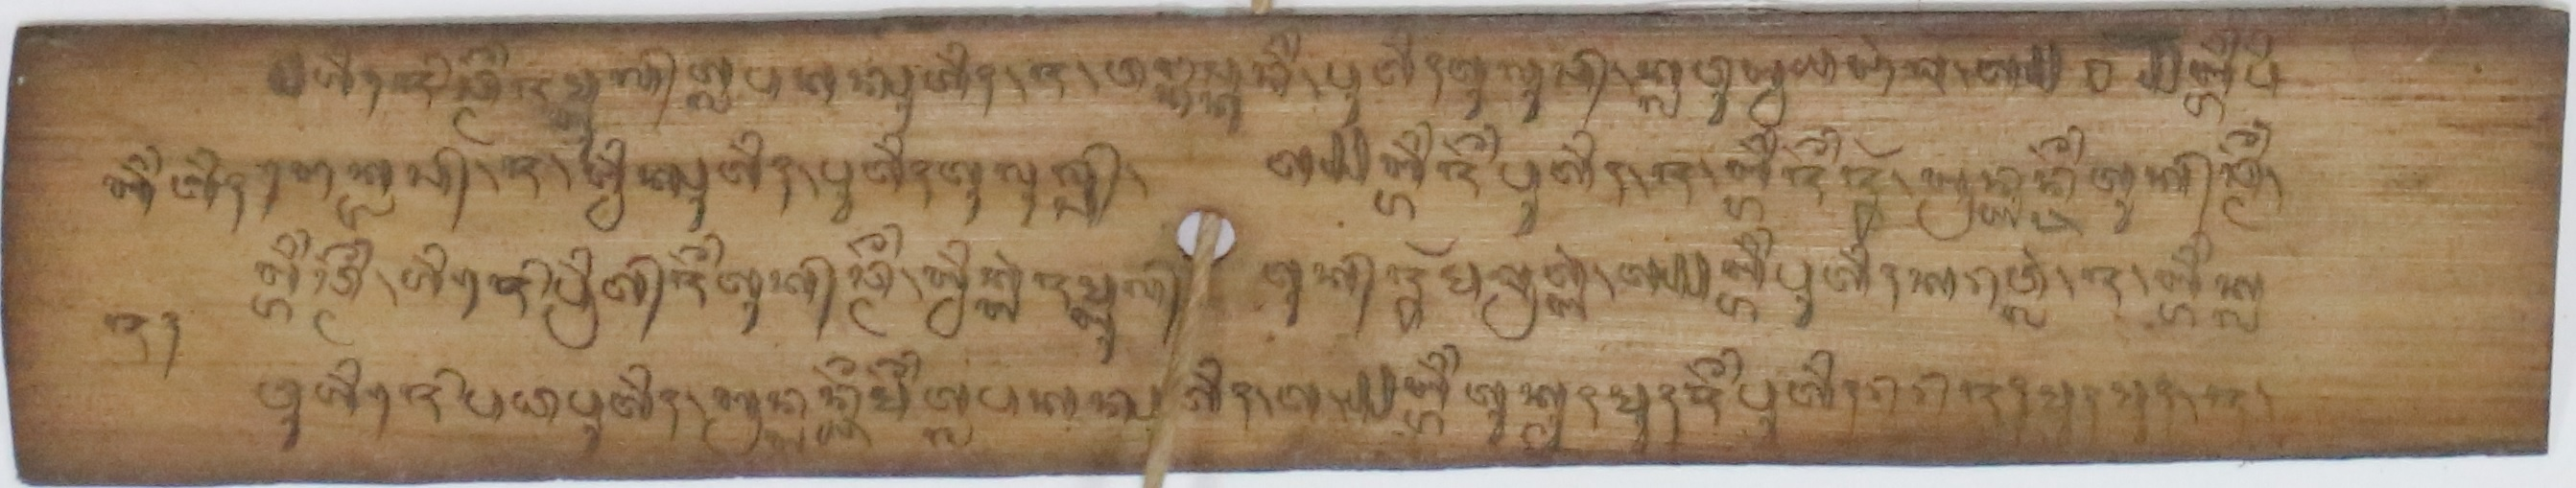

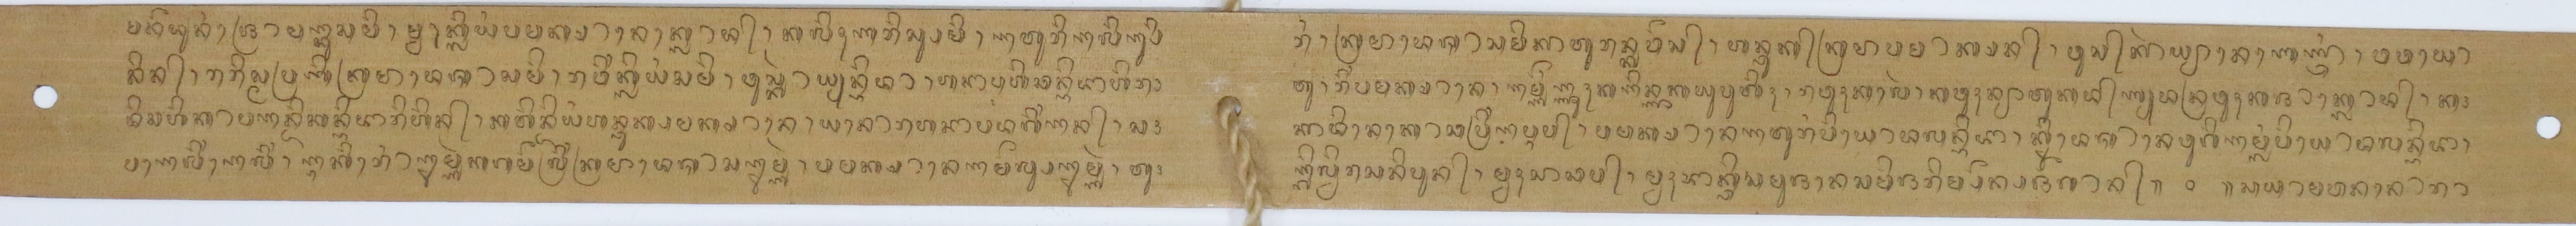

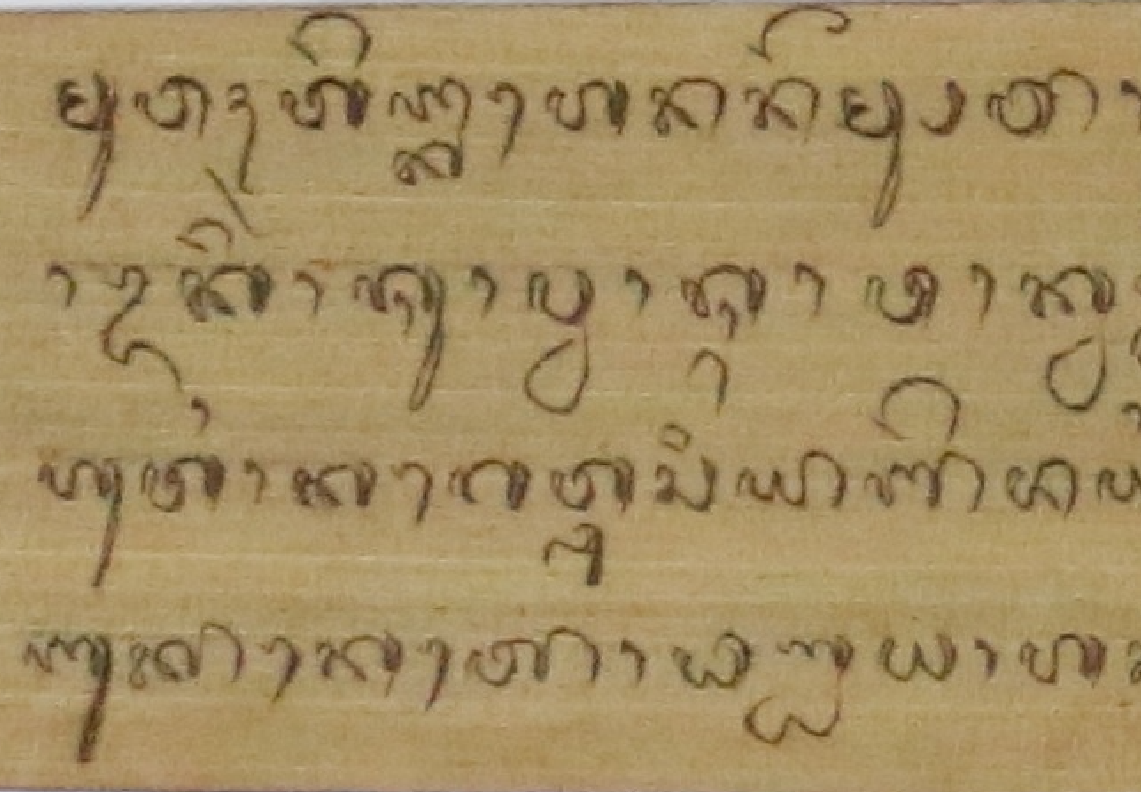

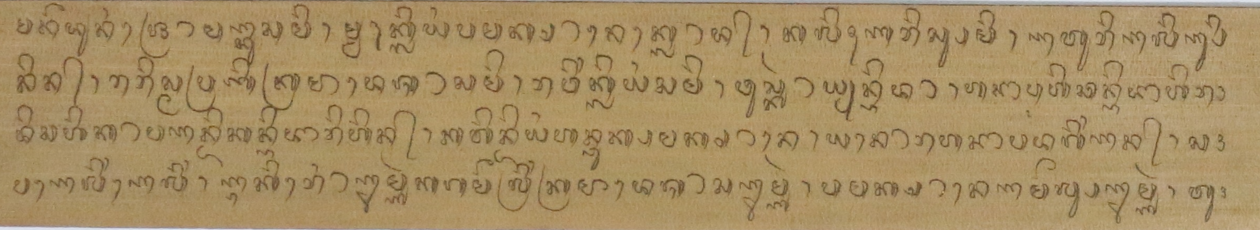

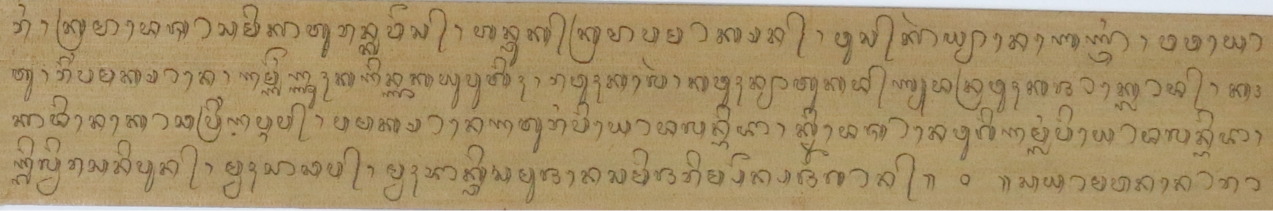

In [5]:
from IPython.display import Image, display

image_list, _, _ = file_utils.get_files('images/')

for imageName in image_list:
    display(Image(filename=imageName))

C:\ProgramData\Anaconda3\envs\craft_model\lib\site-packages\torchvision\models\_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\craft_model\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\craft_model\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


images/
Loading weights from checkpoint (weights/craft_mlt_25k.pth)


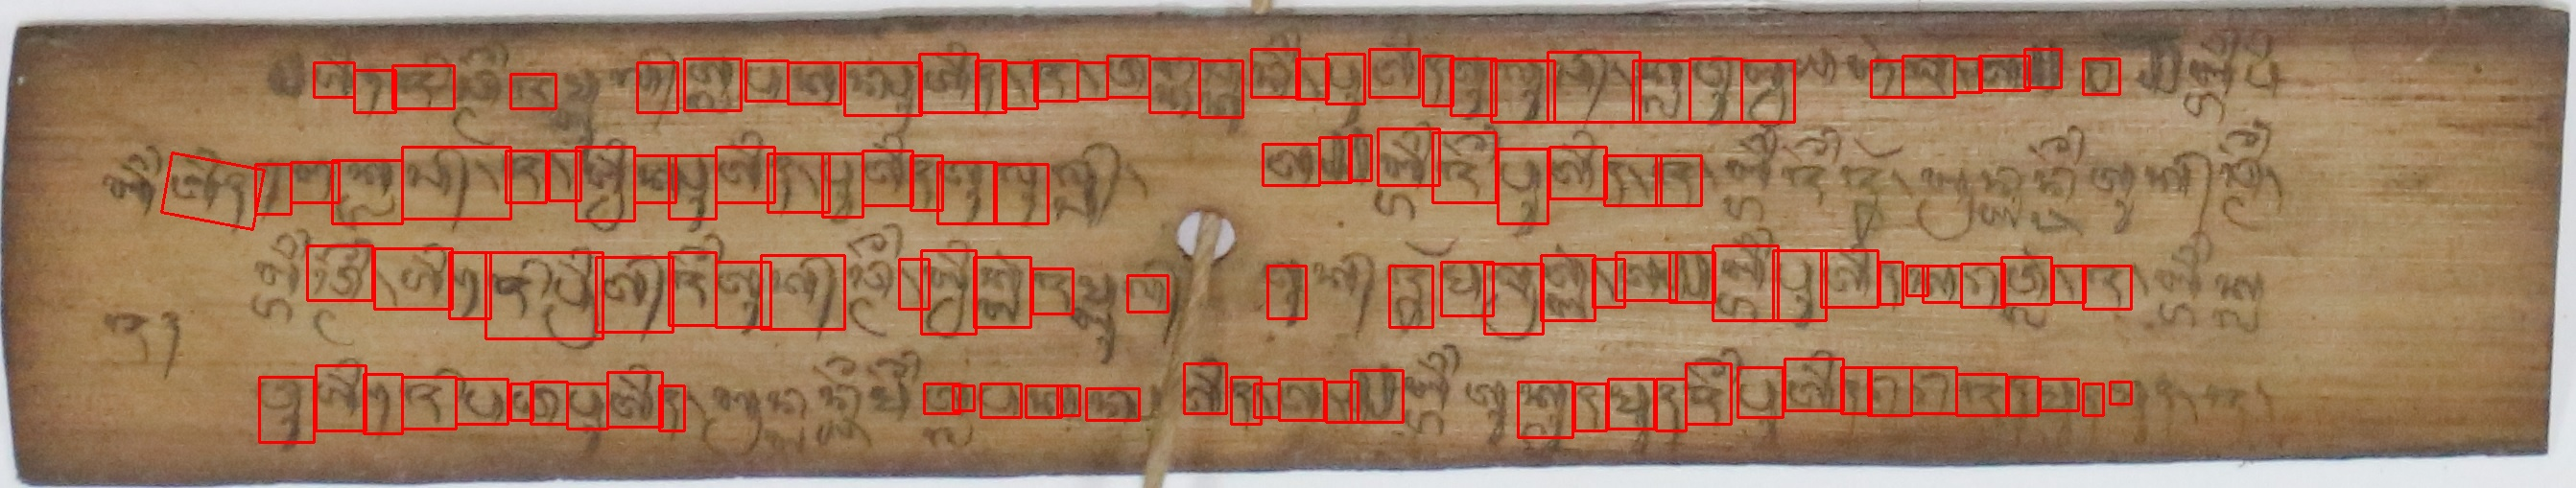

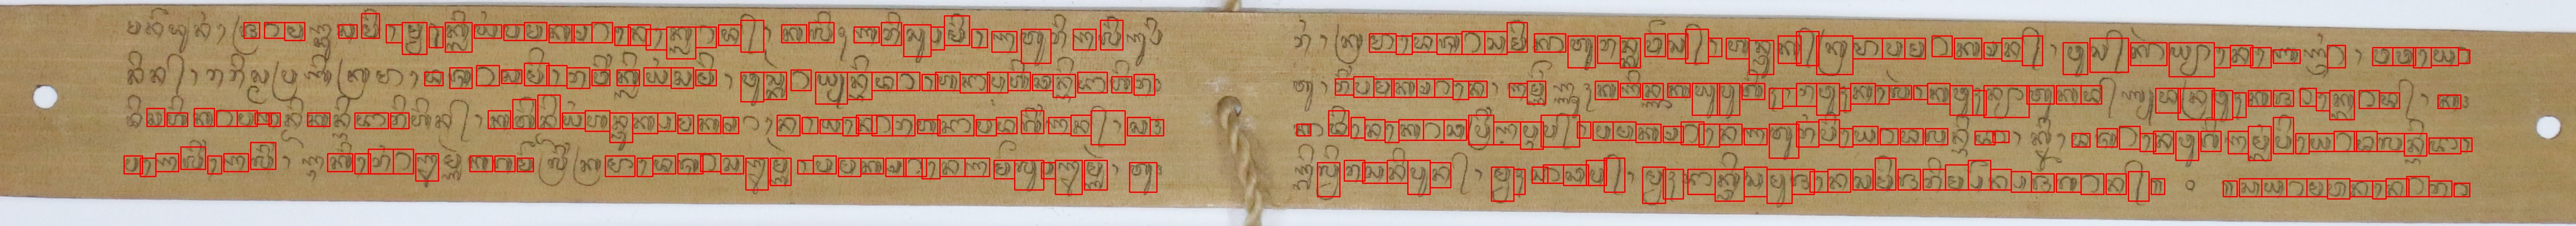

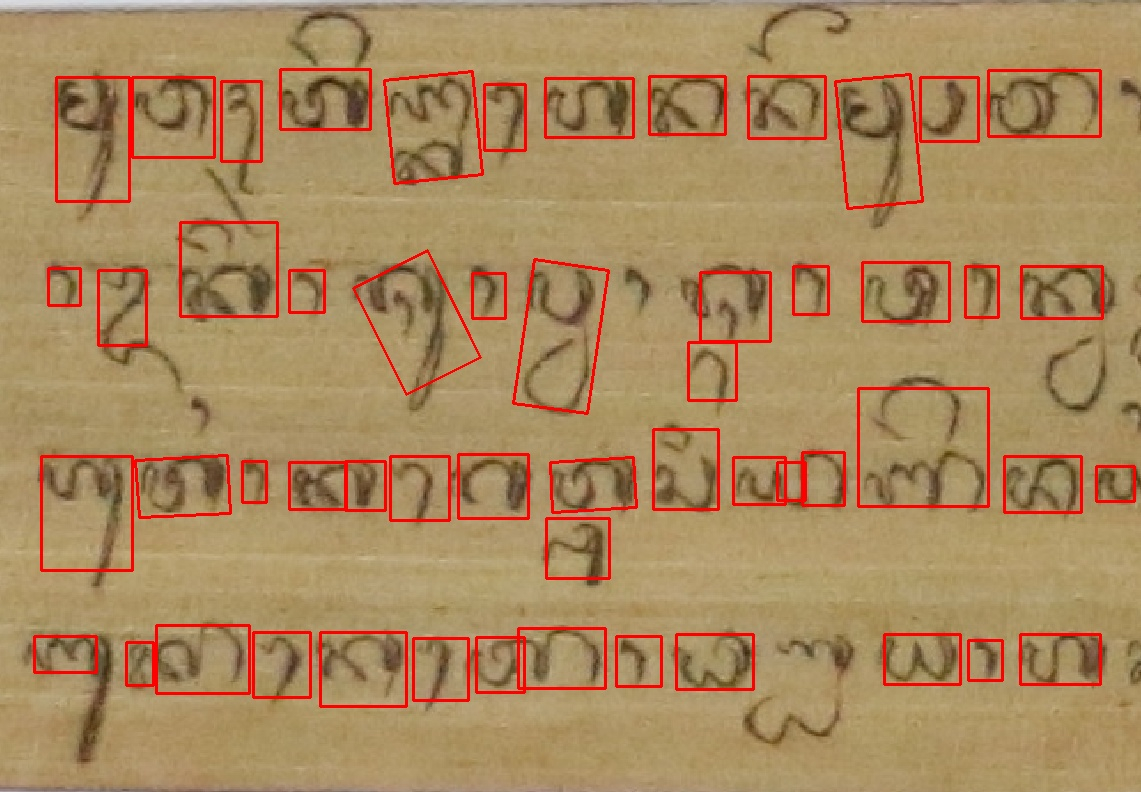

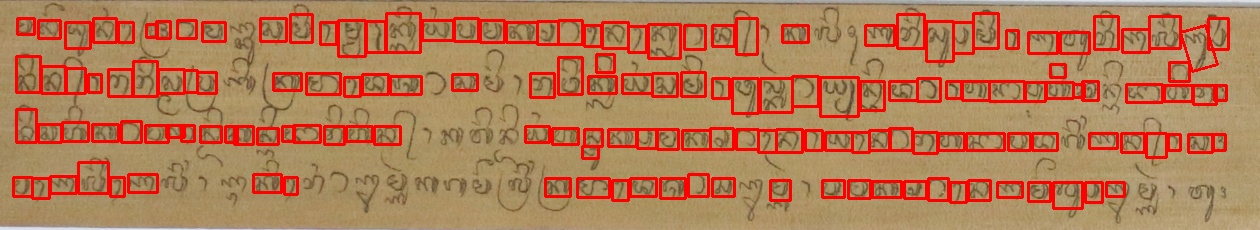

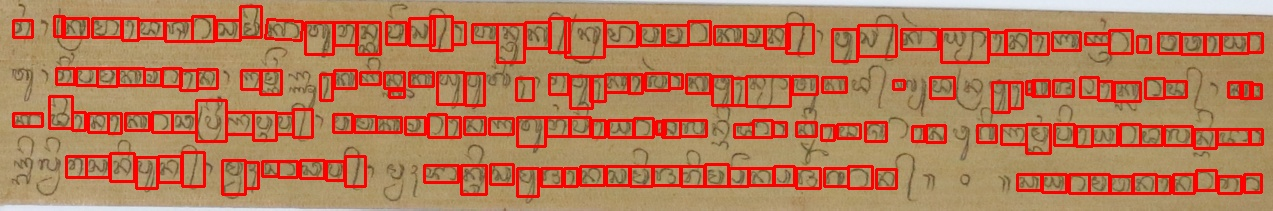

elapsed time : 161.94943571090698s


In [6]:
craft('images/')

In [2]:
img = cv.imread('images/image14.jpg')
cropped = img[200:300, 150:250]
zoomed = zoom(img, 3)
zoomed_and_cropped = zoom(cropped, 3)

In [9]:
??imgproc.loadImage

In [10]:
def loadImage(img):          # RGB order
    if img.shape[0] == 2: img = img[0]
    if len(img.shape) == 2 : img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[2] == 4:   img = img[:,:,:3]
    img = np.array(img)
    return img

In [12]:
import cv2 as cv
import file_utils
def zoom(img, zx=10,zy=15):
    return cv.resize(img, None, fx=zx, fy=zy)

In [13]:
img = cv.imread('images/image14.jpg')
cropped = img[0:img.shape[0],200:1400]
zoomed = zoom(img)
zoomed_and_cropped = zoom(cropped)

In [1]:
from PIL import ImageDraw


In [15]:
def test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net=None):
    t0 = time.time()
    canvas_size=2280
    mag_ratio=1.5
    show_time=False
    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    with torch.no_grad():
        y, feature = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    # refine link
    if refine_net is not None:
        with torch.no_grad():
            y_refiner = refine_net(y, feature)
        score_link = y_refiner[0,:,:,0].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()

    # Post-processing
    boxes, polys = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

    # coordinate adjustment
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)
    polys = craft_utils.adjustResultCoordinates(polys, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]

    t1 = time.time() - t1

    # render results (optional)
    render_img = score_text.copy()
    render_img = np.hstack((render_img, score_link))
    ret_score_text = imgproc.cvt2HeatmapImg(render_img)

    if show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes, polys, ret_score_text


In [22]:
def crafttry(img):
    net = CRAFT()     # initialize
    trained_model='weights/craft_mlt_25k.pth'
    text_threshold=0.7
    low_text=0.5
    link_threshold=.9
    cuda=False
    canvas_size=1280
    
    poly=False
    
    refine=False
    refiner_model='weights/craft_refiner_CTW1500.pth'
    
    result_folder = './result/'
    if not os.path.isdir(result_folder):
        os.mkdir(result_folder)
    print('Loading weights from checkpoint (' + trained_model + ')')
    if cuda:
        net.load_state_dict(copyStateDict(torch.load(trained_model)))
    else:
        net.load_state_dict(copyStateDict(torch.load(trained_model, map_location='cpu')))

    if cuda:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()

    # LinkRefiner
    refine_net = None
    if refine:
        from refinenet import RefineNet
        refine_net = RefineNet()
        print('Loading weights of refiner from checkpoint (' + refiner_model + ')')
        if cuda:
            refine_net.load_state_dict(copyStateDict(torch.load(refiner_model)))
            refine_net = refine_net.cuda()
            refine_net = torch.nn.DataParallel(refine_net)
        else:
            refine_net.load_state_dict(copyStateDict(torch.load(refiner_model, map_location='cpu')))

        refine_net.eval()
        poly = True

    t = time.time()

    # load data
#     print("Test image {:d}/{:d}: {:s}".format(k+1, len(image_list), image_path), end='\r')
    image =loadImage(img)

    bboxes, polys, score_text = test_net(net, image, text_threshold, link_threshold, low_text, cuda, poly, refine_net)
#         print(bboxes)
        # save score text
#     filename, file_ext = os.path.splitext(os.path.basename(image_path))
    mask_file = result_folder + "/vallires_crop_mask.jpg"
    cv2.imwrite(mask_file, score_text)
    
    file_utils.saveResult("/", image[:,:,::-1], polys, dirname=result_folder)
    f1 = result_folder + "/res_.jpg"
    display(Image(filename=f1))

    print("elapsed time : {}s".format(time.time() - t))


In [23]:
crafttry(zoomed_and_cropped)

Loading weights from checkpoint (weights/craft_mlt_25k.pth)


TypeError: 'module' object is not callable